# CM 3070 Final Project

## CoCurricular Classification for University Advancement

Brian Van Steen 210182781

<a id='toc'></a>

### [1. Set Up](#setup)

### [2. Dataset](#dataset)

### [3. Visualizations](#visuals)

### [4. Binary Analysis](#binary)

#### - [4.1 Logistic Regression](#logreg)

#### - [4.2 Multi-Class Logistic Regression](#multilogreg)

#### - [4.3 Decision Tree](#dtree)

### [5. Categorical Analysis](#categorical)

#### - [5.1 Decision Tree](#catDT)

#### - [5.2 Naive Bayes](#catNB)

#### - [5.3 XGBoost](#catXGB)

<a id='setup'></a>
# 1. Set Up

This project is built using Anaconda JupyterLab, and a dedicated virtual environment was built for this notebook.

The following libraries were installed using 'pip' in the virtual environment terminal:

- NumPy
- Pandas
- Matplotlib
- Seaborn
- scikit-learn
- jupyterlab-git
- pyLDAvis
- TensorFlow
- openpyxl

Each of these libraries can now be imported for use.

In [1]:
# install all libraries

import numpy as np # Python library for working with arrays
import pandas as pd # Python library for data processing, working with CSV files
import matplotlib.pyplot as plt # used for basic visualzations and graph creations
%matplotlib inline
import seaborn as sns # used for advanced visualizations and graph creations

import nltk # import NLTK library for natural language processing
import re # import regular expression library for text pre-processing
import tokenization # import tokenization library
import string # import string library for string pre-processing
from itertools import product
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split # use for Splitting the data between training data and test data
from sklearn.preprocessing import MinMaxScaler # for normalization
from sklearn.preprocessing import PolynomialFeatures # for multivariate polynomial regression
from sklearn.tree import DecisionTreeClassifier # for cross-validation
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV # logistic regression
from sklearn.naive_bayes import MultinomialNB # Naive Bayes
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import mean_squared_error # library for calculating metric
from sklearn.metrics import r2_score # library for calculating metric
from sklearn.metrics import accuracy_score

import tensorflow as tf
import keras
from keras import layers

import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

In [2]:
# as there are 23 attributes, show all columns when examining all data
pd.set_option('display.max_columns', None)

_[Table of Contents](#toc)_

<a id='dataset'></a>
# 2. Dataset

The dataset is provided by a Canadian university, consisting of all students who completed a degree or are in the processing of completing a degree, and who participate in co-curricular activities.

This dataset is created in an Excel .xlsx format, and was pre-processed in Excel as part of initial exploratory data analysis (EDA). While examining the data, the following pre-processing was completed:

- there were students included that did not have any data except the first three columns, implying they were not actually a student, and so these rows were deleted
- multiple columns were deleted for fields that were not relevant to co-curricular or donation activities
- the data was anonymized
- the columns heading were re-named and shortened, for ease-of-use

To start, the co-curricular dataset will be imported.

In [3]:
# import university co-curricular dataset as DataFrame from .xlsx file
# this required the install of openpyxl from the virtual environment terminal
prelimDataset = pd.read_excel('..\\Preliminary\\preliminaryReportData.xlsx')

In [4]:
# initial summary view of the DataFrame, the preliminary report dataset
prelimDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60996 entries, 0 to 60995
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ClassifierCode       60996 non-null  object        
 1   ActivityYear         60996 non-null  object        
 2   ActivityCategory     60996 non-null  object        
 3   PostCode             55836 non-null  object        
 4   Constituent          60996 non-null  object        
 5   GraduationYear       56932 non-null  datetime64[ns]
 6   Faculty              56932 non-null  object        
 7   Degree               56932 non-null  object        
 8   Exclusions           2587 non-null   object        
 9   LifetimeDollars      15377 non-null  float64       
 10  LifetimeGifts        15377 non-null  float64       
 11  RFMRC                15409 non-null  float64       
 12  RFMFR                15409 non-null  float64       
 13  RFMMO                15409 non-

### 2.1 Preliminary Summary

After initial cleansing the data in Excel, the preliminary data set included 60,996 records that represent anonymized information for the university students.

The co-curricular data that will be analyzed in this study are in the second and third columns, AcitivityYear and ActivityCategory. These represent activities undertaken by students while studying at univeristy

The rest of the columns details information about the student, including a mailing postal code, faculty and degree completed, graduation year, and donation information.

An overview of the data is shown below.

In [5]:
prelimDataset.head()

,ClassifierCode,ActivityYear,ActivityCategory,PostCode,Constituent,GraduationYear,Faculty,Degree,Exclusions,LifetimeDollars,LifetimeGifts,RFMRC,RFMFR,RFMMO,RFMTO,FirstGiftYear,FirstAmount,FirstArea,FirstSolicitation,LargestGiftYear,LargestAmount,LargestArea,LargestSolicitation
0,6K223BZ,2010-2011,"Education, Training and Outreach",K2,Alumnus,2008-10-24,Faculty:Arts & Social Sciences,Bachelor of Arts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,KBZ43K4,2015-2016,Student Government and Student and Residence Life,K2,Alumnus Parent employee,2017-02-17,Faculty:Public Affairs,Bachelor of Arts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,KBZ43K4,2014-2015,"Panels, Events, Committees and Conferences",K2,Alumnus Parent employee,2017-02-17,Faculty:Public Affairs,Bachelor of Arts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
3,KBZ43K4,2014-2015,"Panels, Events, Committees and Conferences",K2,Alumnus Parent employee,2017-02-17,Faculty:Public Affairs,Bachelor of Arts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
4,KKK0BZ0,2012-2013,"Academics, Awards and Research",K1,Alumnus,2016-05-27,Faculty:Public Affairs,Bachelor of Arts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN


### 2.2 Update

Based on additional analysis of the data, as well as the opportunity to append additional data, the dataset was updated and further **dataset type** pre-processing was applied.

In addition to the co-curricular activities, post graduation alumni activities were added to the dataset. Additionally, it was identified that an additional co-curricular field would be used that have previously been dropped.

Additionally, as each co-curricular activity undertaking by the student is represented by a single row, a student can appear in multiple rows. While this was useful for tracking the co-curricular activities, singular data for the student is then repeated. For example, in the overview above, student 'KBZ43K4' (annonymized) has three rows of co-curricular activities over two years (2014 - 2015, ad 2015 - 2016). But that student only has one postal code, graduation year, faculty, etc.

Therefore, the 60,996 needed to be collapsed based on the 'ClassifierCode' while retaining all the co-curricular data as well as the 'singular' datapoints. Based on research and given the data is in an Excel format, the best solution identified was using an Excel Power Query, to transform the data with a 'Group By' | 1 |. Using a Power Query script, all the rows were grouped using the ClassifiedCode, all co-curricular data was concatenated into a single columns (ActivityYear, ActivityCategory, and ActivityDepartment), and then the singular data were returned as single values using a 'max' evaluation.

In preparation for the Power Query script, further data cleansing was applied in Excel, since the Power Query effort was completed in Excel. This clenasing included rationalizing duplicated co-curricular values (i.e., equivalent values that used 'and' as well as '&') as well as anonymizing the ActivityDepartment co-curricular field.

Finally, all the concatenated data need to be split, to enable categorical encoding during the machine learning processes. While this can be easily done in pandas using string.split methods, this was completed in Excel since it was just a continuation of the Power Query process. In Excel, the 'Text to Column' function allows delimited data in one column to be split into multiple columns based on the delimiter.

As part of the research to identify a method to collapse the rows, it was attempted to identify a pandas method that would achieve the same result. While the functionality exists to collapsed rows based on an ID using pandas | 2 |, I could not identify a pandas method that would both concatenate multiple data points for some columns while also returning on a single value for singular data. A more recent dataframe library, Polars, may have additional functionality, but searches related to Polars did not return anything.

| 1 | https://community.fabric.microsoft.com/t5/Power-Query/Combining-Rows-based-on-the-ID-of-that-table/td-p/2374464

| 2 | https://stackoverflow.com/questions/70505040/pandas-collapse-rows-with-same-column-id-and-concatenate-multiple-columns-into

In [6]:
# import updated university co-curricular dataset as DataFrame from .xlsx file
studentDataset = pd.read_excel('..\\..\\Data\\coCurricularFinal.xlsx')

In [7]:
studentDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17714 entries, 0 to 17713
Data columns (total 66 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Sort                 17714 non-null  object        
 1   RFMRC                17714 non-null  int64         
 2   RFMFR                17714 non-null  int64         
 3   RFMMO                17714 non-null  int64         
 4   RFMTO                17714 non-null  int64         
 5   Exclusions           707 non-null    object        
 6   Postal               17714 non-null  object        
 7   StartYear            17714 non-null  int64         
 8   Cat1                 17714 non-null  object        
 9   Cat2                 10712 non-null  object        
 10  Cat3                 7318 non-null   object        
 11  Cat4                 5314 non-null   object        
 12  Cat5                 4012 non-null   object        
 13  Cat6                 3115 non-n

### 2.3 Final Summary

Based on the updated dataset that was collapse, we now have the following records, as detailed above:

- 17,714 individual student records (versus 60,996 total records), implying each student on average participated in more than 3 co-curricular activities
- specific data for these 17,714 students, including PostalCode, StartYear and Constituent
- of these, there are 4,377 target labels for students that have made donations (RFMRC, RFMFR, RFMMO, RFMTO)
- the donation data for the 4,363 students that made donations (the discrepency is individuals who have donated through a company)
- the split co-curricular data is now captured in individual fields, Cat 1 - 16, and Dept 1 - 16
- the appended alumni activity data is also captured in individual fields, Activity 1 - 12

As shown above, all 17,714 students have a least one co-curricular activity shown in Cat1 and Dept1. But the number of students with greater number of activities drops off for the higher valued Cat and Dept fields.

Additionally, while a large number of alumni participated in post-graduation activities (10,445 for Activity1), the number decreases significantly for higher values Activity fields.

A summary of the dataset is shown below.

In [8]:
studentDataset.head()

,Sort,RFMRC,RFMFR,RFMMO,RFMTO,Exclusions,Postal,StartYear,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,Cat11,Cat12,Cat13,Cat14,Cat15,Cat16,Dept1,Dept2,Dept3,Dept4,Dept5,Dept6,Dept7,Dept8,Dept9,Dept10,Dept11,Dept12,Dept13,Dept14,Dept15,Dept16,Constituent,Graduation,Faculty,Degree,LifetimeDollars,LifetimeGifts,FirstYear,FirstAmount,FirstArea,FirstSolicitation,LargestYear,LargestAmount,LargestArea,LargestSolicitation,Activity1,Activity2,Activity3,Activity4,Activity5,Activity6,Activity7,Activity8,Activity9,Activity10,Activity11,Activity12
0,8g31t83,20,15,6,41,NaN,T2,2012,Academic Success,Academic Success,Athletics and Recreation,Athletics and Recreation,Athletics and Recreation,Athletics and Recreation,Athletics and Recreation,Education and Outreach,Student Life Programs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Learning Support Services,University Administrative Department,Athletics,Athletics,Athletics,Athletics,University Administrative Department,Employability,Student Government,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alumnus,2017-06-02,Public Affairs,Bachelor of Arts,3525.00,63,2017-11-29,300,Athletics,Email,2021-12-03,1500,Athletics,Email,Alumni Athletics Volunteer,Alumni Association Executive,Alumni Association Executive,Alumni Volunteer,Alumni Volunteer,Student Residence,Student Sports,NaN,NaN,NaN,NaN,NaN
1,8gX1t83,0,0,0,0,NaN,K1,2010,Academic Success,Academic Success,Academic Success,Leadership and Development,Leadership and Development,Leadership and Development,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Education and Outreach,Special Events,Student Life Programs,NaN,NaN,NaN,Learning Support Services,Learning Support Services,University Administrative Department,Academic Improvement,Academic Improvement,Academic Improvement,University School of Journalism and Communica...,University School of Journalism and Communica...,University School of Journalism and Communica...,Student Government,Accessibility,University Administrative Department,University Orientation,NaN,NaN,NaN,Alumnus Employee,2014-05-30,Public Affairs,Bachelor of Arts,0.00,0,NaT,0,NaN,NaN,NaT,0,NaN,NaN,Alumni Association Executive,Alumni Association Executive,Alumni Volunteer,Student Residence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ygz1t8,20,20,2,42,NaN,K1,2012,Academic Success,Academic Success,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Competition Team,Competition Team,Special Events,Special Events,Special Events,Special Events,Student Life Programs,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,University Student Engineering Society,University Student Engineering Society,Faculty of Engineering,University Student Engineering Society,Faculty of Engineering,University Administrative Department,University Administrative Department,University Administrative Department,University Orientation,Alumnus,2017-06-02,Engineering & Design,Bachelor of Engineering,654.75,234,2013-04-09,50,Faculty:Engineering & Design,Levy,2019-07-04,75,University Wide,Email,Student Volunteer,Alumni Association Executive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6gZ1t83,0,0,0,0,NaN,J9,2010,Leadership and Development,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Student Government,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alumnus,2009-05-29,School of Business,Bachelor of Commerce,0.00,0,NaT,0,NaN,NaN,NaT,0,NaN,NaN,Alumni Award Winner,Alumni Award Winner Winner,Alumni Volunteer,Alumni Profiled in Publication,Student Residence,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3g21t87,0,0,0,0,NaN,K2,2010,Clubs/Societies/Associations,Leadership and Development,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,School of Business,School of Business,NaN,NaN,NaN,NaN,

### 2.4 Data Pre-processing

Based on the summary, a few fields require additional **data-oriented** preprocessing, as follows.

There are many 'NaN' values, since some students participated in many co-curricular activities, while most only participated in a few.

Additionally, there are 1,446 students who are currently studying at university, so data for graduation, factulty and degree at missing.

Finally, only students who have made a donation have RFM labels.

The only fields that should have numerical data are then shown with their statistical values.

In [9]:
studentDataset.describe()

,RFMRC,RFMFR,RFMMO,RFMTO,StartYear,Graduation,LifetimeDollars,LifetimeGifts,FirstYear,FirstAmount,LargestYear,LargestAmount
count,17714.000000,17714.000000,17714.000000,17714.000000,17714.000000,16268,17714.000000,17714.000000,4363,17714.000000,4363,17714.000000
mean,2.666987,2.937902,0.519702,6.124478,2015.039178,2018-04-09 14:55:26.481435904,61.817601,3.957435,2016-07-09 15:58:07.783635200,14.344981,2017-12-15 23:20:23.653449728,24.266343
min,0.000000,0.000000,0.000000,0.000000,2009.000000,1981-11-15 00:00:00,0.000000,0.000000,1985-04-15 00:00:00,0.000000,2000-01-14 00:00:00,0.000000
25%,0.000000,0.000000,0.000000,0.000000,2012.000000,2015-05-29 00:00:00,0.000000,0.000000,2013-04-09 00:00:00,0.000000,2014-12-04 00:00:00,0.000000
50%,0.000000,0.000000,0.000000,0.000000,2015.000000,2018-06-01 00:00:00,0.000000,0.000000,2017-03-13 00:00:00,0.000000,2018-04-13 00:00:00,0.000000
75%,0.000000,0.000000,0.000000,0.000000,2018.000000,2021-06-18 00:00:00,0.000000,0.000000,2020-01-16 12:00:00,0.000000,2021-03-09 00:00:00,0.000000
max,20.000000,20.000000,50.000000,70.000000,2023.000000,2023-06-07 00:00:00,18724.000000,784.000000,2023-10-18 00:00:00,2250.000000,2023-10-18 00:00:00,6203.000000
std,6.214501,5.359001,1.053838,11.563263,3.444086,NaN,301.921588,17.149681,NaN,69.265709,NaN,144.244446


In [10]:
# checking for studentDataset cells with 'NaN' as value
studentDataset.isnull().sum()

Sort              0
RFMRC             0
RFMFR             0
RFMMO             0
RFMTO             0
              ...  
Activity8     17707
Activity9     17710
Activity10    17710
Activity11    17712
Activity12    17713
Length: 66, dtype: int64

In [11]:
# reset date-type columns using just the 'year' data from the existing datatime dtype columns, and set all as objects
studentDataset['StartYear'] = studentDataset['StartYear'].astype(object)
studentDataset['Graduation'] = pd.to_datetime(studentDataset['Graduation'], errors='coerce').dt.year.astype(object)
studentDataset['FirstYear'] = pd.to_datetime(studentDataset['FirstYear'], errors='coerce').dt.year.astype(object)
studentDataset['LargestYear'] = pd.to_datetime(studentDataset['LargestYear'], errors='coerce').dt.year.astype(object)

For the donation and RFM data, all 'NaN' values will be replaced with '0', as this accruately represents the situation.

In [12]:
studentDataset['RFMRC'].fillna(0, inplace = True)
studentDataset['RFMFR'].fillna(0, inplace = True)
studentDataset['RFMMO'].fillna(0, inplace = True)
studentDataset['RFMTO'].fillna(0, inplace = True)
studentDataset['LifetimeDollars'].fillna(0, inplace = True)
studentDataset['LifetimeGifts'].fillna(0, inplace = True)
studentDataset['FirstAmount'].fillna(0, inplace = True)
studentDataset['LargestAmount'].fillna(0, inplace = True)
studentDataset['LifetimeDollars'] = np.where(studentDataset['LifetimeDollars'] < 10, [0], studentDataset['LifetimeDollars'])

In [13]:
studentDataset.describe()

,RFMRC,RFMFR,RFMMO,RFMTO,LifetimeDollars,LifetimeGifts,FirstAmount,LargestAmount
count,17714.000000,17714.000000,17714.000000,17714.000000,17714.000000,17714.000000,17714.000000,17714.000000
mean,2.666987,2.937902,0.519702,6.124478,61.797204,3.957435,14.344981,24.266343
std,6.214501,5.359001,1.053838,11.563263,301.925593,17.149681,69.265709,144.244446
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,20.000000,20.000000,50.000000,70.000000,18724.000000,784.000000,2250.000000,6203.000000


As shown in the statistical table above, there are now 8 fields of numerical data, with 4,377 records of the target lables relating to RFM and 4,363 records for donation amounts.

Some further data cleansing has been identified, as there are 173 records of total donations for less than $10. These are records where a student's payment account has a credit balance, and the student agrees to 'donate' the remaining balance to the university.

As this is more of a 'reactive' than 'proactive' donation, since the values are small in comparison to the 75% level, and since it is a small amount of records, these values will not be included in the analyses.

For all the categorical data, these 'NaN' values will need to be modified specific to the field.

In [14]:
studentDataset['Exclusions'].fillna('Contact', inplace = True) # for these students there are no 'exclusions' for not contacting them
studentDataset['Graduation'].fillna(2030, inplace = True) # for these students who are currently studying, a future year
studentDataset['Faculty'].fillna('NotGraduated', inplace = True) # for these students who are currently studying
studentDataset['Degree'].fillna('NotGraduated', inplace = True) # for these students who are currently studying

In [15]:
# before replacing all remaining 'NaN' value, concatenate all Category, Department and Activity values into individual columns, for TF-IDF analyses
cols1 = ['Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 'Cat7', 'Cat8', 'Cat9', 'Cat10', 'Cat10', 'Cat11', 'Cat12', 'Cat13', 'Cat14', 'Cat15', 'Cat16']
cols2 = ['Dept1', 'Dept2', 'Dept3', 'Dept4', 'Dept5', 'Dept6', 'Dept7', 'Dept8', 'Dept9', 'Dept10', 'Dept10', 'Dept11', 'Dept12', 'Dept13', 'Dept14', 'Dept15', 'Dept16']
cols3 = ['Activity1', 'Activity2', 'Activity3', 'Activity4', 'Activity5', 'Activity6', 'Activity7', 'Activity8', 'Activity9', 'Activity10', 'Activity10', 'Activity11', 'Activity12']
studentDataset["AllCategories"] = studentDataset[cols1].apply(lambda x: ','.join(x.dropna()), axis=1)
studentDataset["AllDepartments"] = studentDataset[cols2].apply(lambda x: ','.join(x.dropna()), axis=1)
studentDataset["AllActivities"] = studentDataset[cols3].apply(lambda x: ','.join(x.dropna()), axis=1)

In [16]:
studentDataset.fillna("None", inplace = True) # replace all remaining 'NaN' values with 'None'

In [17]:
# confirming no 'NaN' values
studentDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17714 entries, 0 to 17713
Data columns (total 69 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sort                 17714 non-null  object 
 1   RFMRC                17714 non-null  int64  
 2   RFMFR                17714 non-null  int64  
 3   RFMMO                17714 non-null  int64  
 4   RFMTO                17714 non-null  int64  
 5   Exclusions           17714 non-null  object 
 6   Postal               17714 non-null  object 
 7   StartYear            17714 non-null  object 
 8   Cat1                 17714 non-null  object 
 9   Cat2                 17714 non-null  object 
 10  Cat3                 17714 non-null  object 
 11  Cat4                 17714 non-null  object 
 12  Cat5                 17714 non-null  object 
 13  Cat6                 17714 non-null  object 
 14  Cat7                 17714 non-null  object 
 15  Cat8                 17714 non-null 

In [18]:
studentDataset.head()

,Sort,RFMRC,RFMFR,RFMMO,RFMTO,Exclusions,Postal,StartYear,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,Cat11,Cat12,Cat13,Cat14,Cat15,Cat16,Dept1,Dept2,Dept3,Dept4,Dept5,Dept6,Dept7,Dept8,Dept9,Dept10,Dept11,Dept12,Dept13,Dept14,Dept15,Dept16,Constituent,Graduation,Faculty,Degree,LifetimeDollars,LifetimeGifts,FirstYear,FirstAmount,FirstArea,FirstSolicitation,LargestYear,LargestAmount,LargestArea,LargestSolicitation,Activity1,Activity2,Activity3,Activity4,Activity5,Activity6,Activity7,Activity8,Activity9,Activity10,Activity11,Activity12,AllCategories,AllDepartments,AllActivities
0,8g31t83,20,15,6,41,Contact,T2,2012,Academic Success,Academic Success,Athletics and Recreation,Athletics and Recreation,Athletics and Recreation,Athletics and Recreation,Athletics and Recreation,Education and Outreach,Student Life Programs,None,None,None,None,None,None,None,Learning Support Services,University Administrative Department,Athletics,Athletics,Athletics,Athletics,University Administrative Department,Employability,Student Government,None,None,None,None,None,None,None,Alumnus,2017.0,Public Affairs,Bachelor of Arts,3525.00,63,2017.0,300,Athletics,Email,2021.0,1500,Athletics,Email,Alumni Athletics Volunteer,Alumni Association Executive,Alumni Association Executive,Alumni Volunteer,Alumni Volunteer,Student Residence,Student Sports,None,None,None,None,None,"Academic Success, Academic Success, Athletics ...","Learning Support Services, University Administ...","Alumni Athletics Volunteer,Alumni Association ..."
1,8gX1t83,0,0,0,0,Contact,K1,2010,Academic Success,Academic Success,Academic Success,Leadership and Development,Leadership and Development,Leadership and Development,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Education and Outreach,Special Events,Student Life Programs,None,None,None,Learning Support Services,Learning Support Services,University Administrative Department,Academic Improvement,Academic Improvement,Academic Improvement,University School of Journalism and Communica...,University School of Journalism and Communica...,University School of Journalism and Communica...,Student Government,Accessibility,University Administrative Department,University Orientation,None,None,None,Alumnus Employee,2014.0,Public Affairs,Bachelor of Arts,0.00,0,None,0,None,None,None,0,None,None,Alumni Association Executive,Alumni Association Executive,Alumni Volunteer,Student Residence,None,None,None,None,None,None,None,None,"Academic Success, Academic Success, Academic S...","Learning Support Services, Learning Support Se...","Alumni Association Executive,Alumni Associatio..."
2,ygz1t8,20,20,2,42,Contact,K1,2012,Academic Success,Academic Success,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Competition Team,Competition Team,Special Events,Special Events,Special Events,Special Events,Student Life Programs,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,University Student Engineering Society,University Student Engineering Society,Faculty of Engineering,University Student Engineering Society,Faculty of Engineering,University Administrative Department,University Administrative Department,University Administrative Department,University Orientation,Alumnus,2017.0,Engineering & Design,Bachelor of Engineering,654.75,234,2013.0,50,Faculty:Engineering & Design,Levy,2019.0,75,University Wide,Email,Student Volunteer,Alumni Association Executive,None,None,None,None,None,None,None,None,None,None,"Academic Success, Academic Success, Clubs/Soci...","Faculty of Engineering, Faculty of Engineering...","Student Volunteer,Alumni Association Executive"
3,6gZ1t83,0,0,0,0,Contact,J9,2010,Leadership and Development,None,None,None,None,None,

In [19]:
studentDataset.loc[studentDataset['Graduation']=='2030']

,Sort,RFMRC,RFMFR,RFMMO,RFMTO,Exclusions,Postal,StartYear,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,Cat11,Cat12,Cat13,Cat14,Cat15,Cat16,Dept1,Dept2,Dept3,Dept4,Dept5,Dept6,Dept7,Dept8,Dept9,Dept10,Dept11,Dept12,Dept13,Dept14,Dept15,Dept16,Constituent,Graduation,Faculty,Degree,LifetimeDollars,LifetimeGifts,FirstYear,FirstAmount,FirstArea,FirstSolicitation,LargestYear,LargestAmount,LargestArea,LargestSolicitation,Activity1,Activity2,Activity3,Activity4,Activity5,Activity6,Activity7,Activity8,Activity9,Activity10,Activity11,Activity12,AllCategories,AllDepartments,AllActivities


_[Table of Contents](#toc)_

<a id='visuals'></a>
# 3. Visualizations

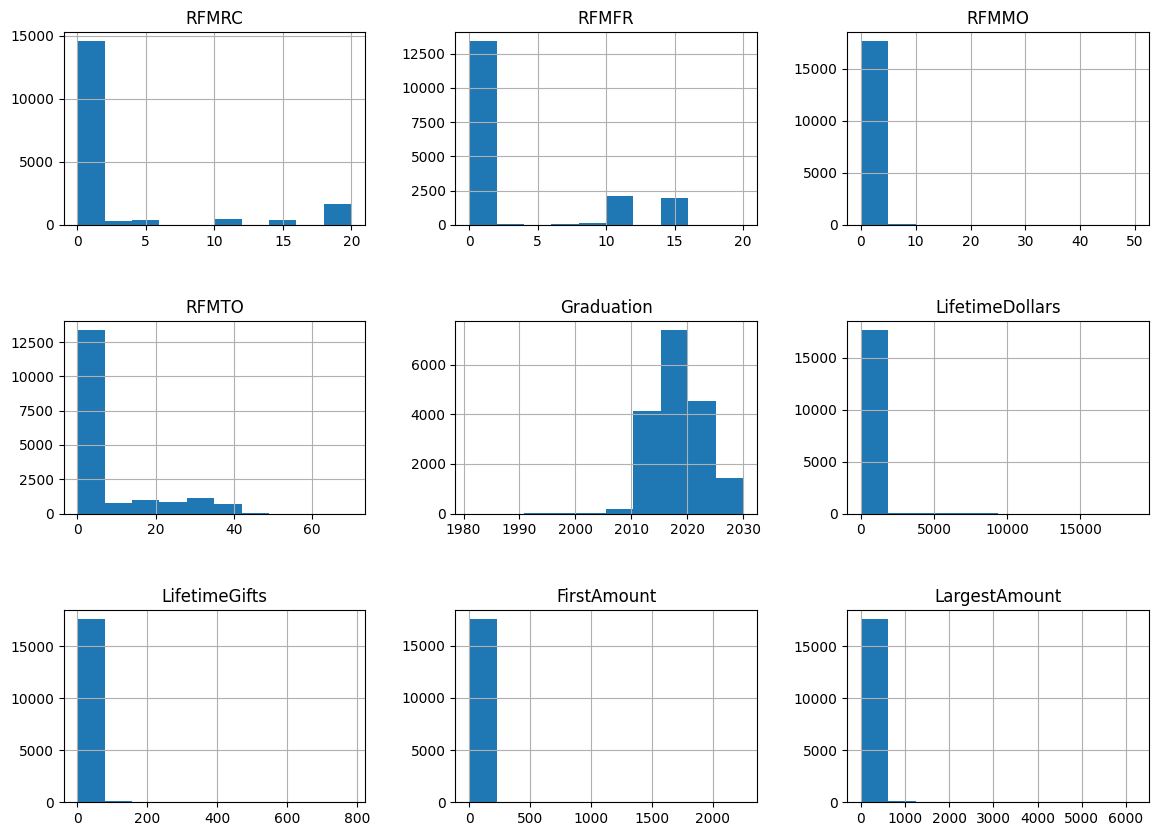

In [20]:
studentDataset.hist(figsize = (14, 10))
plt.subplots_adjust(hspace=0.5) 
plt.show()

The above histograms visually detail what the statistical table documented.

There is a lot of positive skew to the data for donation amounts, with a very small amount of high value outliers.

For the RFM score, aside from the Recency score that is shows many donations completed in the last year, again the data is positively skewed.

For all of these numerical values (except RFM Monetary), large standard deviations are calculated, as documented in the statistical table above.

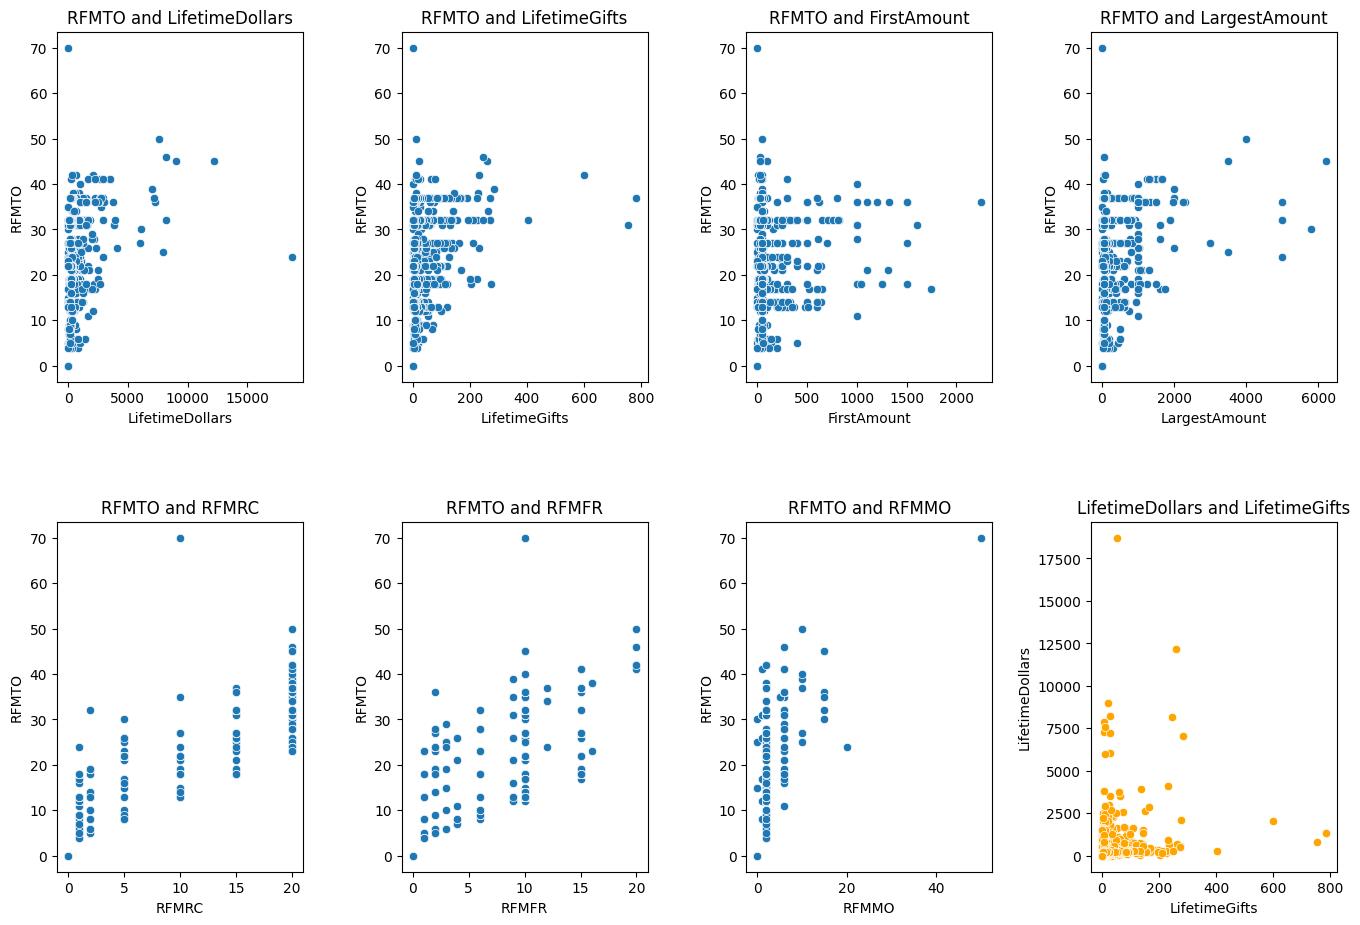

In [21]:
# scatter plots for 8 quantitative values

fig, axs = plt.subplots(2, 4, figsize=(16, 12)) # 8 scatterplots
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.8, wspace=0.4, hspace=0.4)

axs[0, 0].set_title('RFMTO and LifetimeDollars')
axs[0, 0].set_ylabel("RFMTO")
axs[0, 0].set_xlabel("LifetimeDollars")
sns.scatterplot(data = studentDataset, ax = axs[0, 0], x = "LifetimeDollars", y = "RFMTO")

axs[0, 1].set_title('RFMTO and LifetimeGifts')
axs[0, 1].set_ylabel("RFMTO")
axs[0, 1].set_xlabel("LifetimeGifts")
sns.scatterplot(data = studentDataset, ax = axs[0, 1], x = "LifetimeGifts", y = "RFMTO")

axs[0, 2].set_title("RFMTO and FirstAmount")
axs[0, 2].set_ylabel("RFMTO")
axs[0, 2].set_xlabel("FirstAmount")
sns.scatterplot(data = studentDataset, ax = axs[0, 2], x = "FirstAmount", y = "RFMTO")

axs[0, 3].set_title("RFMTO and LargestAmount")
axs[0, 3].set_ylabel("RFMTO")
axs[0, 3].set_xlabel("LargestAmount")
sns.scatterplot(data = studentDataset, ax = axs[0, 3], x = "LargestAmount", y = "RFMTO")

axs[1, 0].set_title("RFMTO and RFMRC")
axs[1, 0].set_ylabel("RFMTO")
axs[1, 0].set_xlabel("RFMRC")
sns.scatterplot(data = studentDataset, ax = axs[1, 0], x = "RFMRC", y = "RFMTO")

axs[1, 1].set_title("RFMTO and RFMFR")
axs[1, 1].set_ylabel("RFMTO")
axs[1, 1].set_xlabel("RFMFR")
sns.scatterplot(data = studentDataset, ax = axs[1, 1], x = "RFMFR", y = "RFMTO")

axs[1, 2].set_title("RFMTO and RFMMO")
axs[1, 2].set_ylabel("RFMTO")
axs[1, 2].set_xlabel("RFMMO")
sns.scatterplot(data = studentDataset, ax = axs[1, 2], x = "RFMMO", y = "RFMTO")

axs[1, 3].set_title("LifetimeDollars and LifetimeGifts")
axs[1, 3].set_ylabel("LifetimeDollars")
axs[1, 3].set_xlabel("LifetimeGifts")
sns.scatterplot(data = studentDataset, ax = axs[1, 3], c = 'orange', x = "LifetimeGifts", y = "LifetimeDollars")

plt.show()

### Pearson Correlation Coefficient

While the focus of this study is on classification, are part of basic EDA the Pearson Correlation Coefficients will be calculated for these numerical values, to evaluate linear correlation.

In [22]:
# calculate Peason correlation coefficient for Price, Year, Mileage and Owners
pearsoncorr = studentDataset[["RFMTO", "RFMRC", "RFMFR", "RFMMO", "LifetimeDollars", "LifetimeGifts", "FirstAmount", "LargestAmount"]].corr(method='pearson')
pearsoncorr

,RFMTO,RFMRC,RFMFR,RFMMO,LifetimeDollars,LifetimeGifts,FirstAmount,LargestAmount
RFMTO,1.000000,0.927611,0.921109,0.818505,0.364532,0.418614,0.323275,0.296636
RFMRC,0.927611,1.000000,0.713692,0.652312,0.282260,0.346310,0.253758,0.237962
RFMFR,0.921109,0.713692,1.000000,0.812996,0.343026,0.427781,0.315850,0.253630
RFMMO,0.818505,0.652312,0.812996,1.000000,0.589108,0.375601,0.444885,0.561940
LifetimeDollars,0.364532,0.282260,0.343026,0.589108,1.000000,0.335440,0.393890,0.868495
LifetimeGifts,0.418614,0.346310,0.427781,0.375601,0.335440,1.000000,0.126920,0.183939
FirstAmount,0.323275,0.253758,0.315850,0.444885,0.393890,0.126920,1.000000,0.553722
LargestAmount,0.296636,0.237962,0.253630,0.561940,0.868495,0.183939,0.553722,1.000000


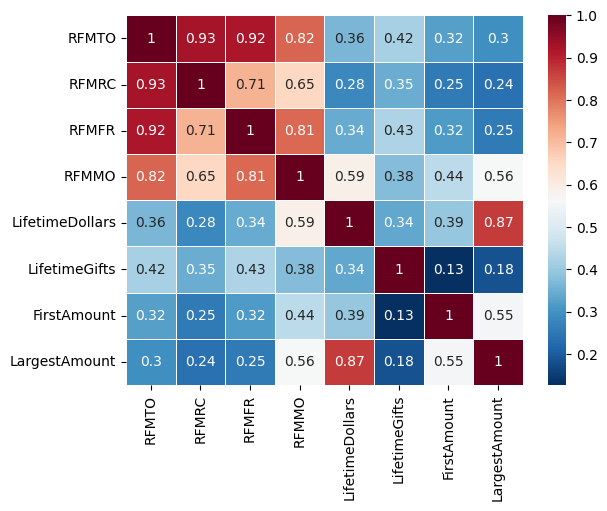

In [23]:
# visualize the correlation coefficient values from the table above
sns.heatmap(pearsoncorr, xticklabels=pearsoncorr.columns, yticklabels=pearsoncorr.columns, cmap='RdBu_r', annot=True, linewidth=0.5);

As shown in the red sections of the heat map, there is expected higher levels of correlation between RFM Monetary scores, lifetime dollars and large donation amounts.

_[Table of Contents](#toc)_

<a id='binary'></a>
# 4. Binary Analysis

In [24]:
studentDataset['binaryRFMRC'] = np.select([studentDataset['RFMRC'] < 10], [0], 1).astype('int')
studentDataset['binaryRFMFR'] = np.select([studentDataset['RFMFR'] < 10], [0], 1).astype('int')
studentDataset['binaryRFMMO'] = np.select([studentDataset['RFMMO'] < 10], [0], 1).astype('int')
studentDataset['binaryRFMTO'] = np.select([studentDataset['RFMTO'] < 10], [0], 1).astype('int')
studentDataset['labelRFMRC'] = np.select([studentDataset['RFMRC'] < 5, studentDataset['RFMRC'].between(5, 10), studentDataset['RFMRC'].between(10, 14)], [0, 1, 2], 3)
studentDataset['labelRFMFR'] = np.select([studentDataset['RFMFR'] < 5, studentDataset['RFMFR'].between(5, 10), studentDataset['RFMFR'].between(10, 15), studentDataset['RFMFR'].between(15, 20)], [0, 1, 2, 3], 4).astype('int')
studentDataset['labelRFMMO'] = np.select([studentDataset['RFMMO'] < 10, studentDataset['RFMMO'].between(10, 20), studentDataset['RFMMO'].between(20, 30), studentDataset['RFMMO'].between(30, 40)], [0, 1, 2, 3], 4).astype('int')
studentDataset['labelRFMTO'] = np.select([studentDataset['RFMTO'] < 10, studentDataset['RFMTO'].between(10, 20), studentDataset['RFMTO'].between(20, 30), studentDataset['RFMTO'].between(30, 40)], [0, 1, 2, 3], 4).astype('int')

In [25]:
studentDataset.head()

,Sort,RFMRC,RFMFR,RFMMO,RFMTO,Exclusions,Postal,StartYear,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,Cat11,Cat12,Cat13,Cat14,Cat15,Cat16,Dept1,Dept2,Dept3,Dept4,Dept5,Dept6,Dept7,Dept8,Dept9,Dept10,Dept11,Dept12,Dept13,Dept14,Dept15,Dept16,Constituent,Graduation,Faculty,Degree,LifetimeDollars,LifetimeGifts,FirstYear,FirstAmount,FirstArea,FirstSolicitation,LargestYear,LargestAmount,LargestArea,LargestSolicitation,Activity1,Activity2,Activity3,Activity4,Activity5,Activity6,Activity7,Activity8,Activity9,Activity10,Activity11,Activity12,AllCategories,AllDepartments,AllActivities,binaryRFMRC,binaryRFMFR,binaryRFMMO,binaryRFMTO,labelRFMRC,labelRFMFR,labelRFMMO,labelRFMTO
0,8g31t83,20,15,6,41,Contact,T2,2012,Academic Success,Academic Success,Athletics and Recreation,Athletics and Recreation,Athletics and Recreation,Athletics and Recreation,Athletics and Recreation,Education and Outreach,Student Life Programs,None,None,None,None,None,None,None,Learning Support Services,University Administrative Department,Athletics,Athletics,Athletics,Athletics,University Administrative Department,Employability,Student Government,None,None,None,None,None,None,None,Alumnus,2017.0,Public Affairs,Bachelor of Arts,3525.00,63,2017.0,300,Athletics,Email,2021.0,1500,Athletics,Email,Alumni Athletics Volunteer,Alumni Association Executive,Alumni Association Executive,Alumni Volunteer,Alumni Volunteer,Student Residence,Student Sports,None,None,None,None,None,"Academic Success, Academic Success, Athletics ...","Learning Support Services, University Administ...","Alumni Athletics Volunteer,Alumni Association ...",1,1,0,1,3,2,0,4
1,8gX1t83,0,0,0,0,Contact,K1,2010,Academic Success,Academic Success,Academic Success,Leadership and Development,Leadership and Development,Leadership and Development,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Education and Outreach,Special Events,Student Life Programs,None,None,None,Learning Support Services,Learning Support Services,University Administrative Department,Academic Improvement,Academic Improvement,Academic Improvement,University School of Journalism and Communica...,University School of Journalism and Communica...,University School of Journalism and Communica...,Student Government,Accessibility,University Administrative Department,University Orientation,None,None,None,Alumnus Employee,2014.0,Public Affairs,Bachelor of Arts,0.00,0,None,0,None,None,None,0,None,None,Alumni Association Executive,Alumni Association Executive,Alumni Volunteer,Student Residence,None,None,None,None,None,None,None,None,"Academic Success, Academic Success, Academic S...","Learning Support Services, Learning Support Se...","Alumni Association Executive,Alumni Associatio...",0,0,0,0,0,0,0,0
2,ygz1t8,20,20,2,42,Contact,K1,2012,Academic Success,Academic Success,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Competition Team,Competition Team,Special Events,Special Events,Special Events,Special Events,Student Life Programs,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,Faculty of Engineering,University Student Engineering Society,University Student Engineering Society,Faculty of Engineering,University Student Engineering Society,Faculty of Engineering,University Administrative Department,University Administrative Department,University Administrative Department,University Orientation,Alumnus,2017.0,Engineering & Design,Bachelor of Engineering,654.75,234,2013.0,50,Faculty:Engineering & Design,Levy,2019.0,75,University Wide,Email,Student Volunteer,Alumni Association Executive,None,None,None,None,None,None,None,None,None,None,"Academic Success, Academic Success, Clubs/Soci...","Faculty of Engineering, Faculty of Engineering...","Student Vo

In [26]:
def preprocessTweets(text):

    '''
    Clean and join the text
    '''
    
    text = str(text).lower() # convert all text to lower case
    text = ' '.join(word for word in text.split(' ')) # split tweet, remove stop words, re-join words
    return text

In [27]:
# create new column of categoriesAnalysed, departmentsAnalysed, activitiesAnalysed
studentDataset['categoriesAnalysed'] = studentDataset['AllCategories'].apply(preprocessTweets)
studentDataset['departmentsAnalysed'] = studentDataset['AllDepartments'].apply(preprocessTweets)
studentDataset['activitiesAnalysed'] = studentDataset['AllActivities'].apply(preprocessTweets)

In [28]:
cols = ['categoriesAnalysed', 'departmentsAnalysed', 'activitiesAnalysed']
studentDataset['allAnalyzed'] = studentDataset[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [29]:
studentDataset['categoriesAnalysed'] = studentDataset['categoriesAnalysed'].apply(lambda x : x.replace(',',''))
studentDataset['departmentsAnalysed'] = studentDataset['departmentsAnalysed'].apply(lambda x : x.replace(',',''))
studentDataset['activitiesAnalysed'] = studentDataset['activitiesAnalysed'].apply(lambda x : x.replace(',',''))
studentDataset['allAnalyzed'] = studentDataset['allAnalyzed'].apply(lambda x : x.replace(',',''))

In [30]:
studentDataset['allAnalyzed']

0        academic success academic success athletics an...
1        academic success academic success academic suc...
2        academic success academic success clubs/societ...
3        leadership and development student government ...
4        clubs/societies/associations leadership and de...
                               ...                        
17709         volunteer/ambassadors school of linguistics 
17710         volunteer/ambassadors school of linguistics 
17711    volunteer/ambassadors school of public policy ...
17712    volunteer/ambassadors school of public policy ...
17713    volunteer/ambassadors school of public policy ...
Name: allAnalyzed, Length: 17714, dtype: object

In [31]:
studentDataset.sample(frac=1) # shuffle dataset

,Sort,RFMRC,RFMFR,RFMMO,RFMTO,Exclusions,Postal,StartYear,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,Cat7,Cat8,Cat9,Cat10,Cat11,Cat12,Cat13,Cat14,Cat15,Cat16,Dept1,Dept2,Dept3,Dept4,Dept5,Dept6,Dept7,Dept8,Dept9,Dept10,Dept11,Dept12,Dept13,Dept14,Dept15,Dept16,Constituent,Graduation,Faculty,Degree,LifetimeDollars,LifetimeGifts,FirstYear,FirstAmount,FirstArea,FirstSolicitation,LargestYear,LargestAmount,LargestArea,LargestSolicitation,Activity1,Activity2,Activity3,Activity4,Activity5,Activity6,Activity7,Activity8,Activity9,Activity10,Activity11,Activity12,AllCategories,AllDepartments,AllActivities,binaryRFMRC,binaryRFMFR,binaryRFMMO,binaryRFMTO,labelRFMRC,labelRFMFR,labelRFMMO,labelRFMTO,categoriesAnalysed,departmentsAnalysed,activitiesAnalysed,allAnalyzed
13299,9gS1t87,0,0,0,0,Contact,K2,2015,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,Clubs/Societies/Associations,None,None,None,None,None,None,None,None,None,None,None,School of Business,School of Business,School of Business,School of Business,School of Business,None,None,None,None,None,None,None,None,None,None,None,Alumnus,2019.0,School of Business,Bachelor of Commerce,0.00,0,None,0,None,None,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"Clubs/Societies/Associations, Clubs/Societies/...","School of Business, School of Business, School...",,0,0,0,0,0,0,0,0,clubs/societies/associations clubs/societies/a...,school of business school of business school o...,,clubs/societies/associations clubs/societies/a...
16097,9g51t84,0,0,0,0,Contact,K1,2018,Education and Outreach,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Accessibility,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Alumnus,2019.0,Arts & Social Sciences,Bachelor of Arts,0.00,0,None,0,None,None,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Education and Outreach,Accessibility,,0,0,0,0,0,0,0,0,education and outreach,accessibility,,education and outreach accessibility
16429,8gj1t89Z,0,0,0,0,Contact,K2,2011,Education and Outreach,Special Events,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Department of Earth Sciences,Department of Earth Sciences,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Alumnus,2014.0,Science,Bachelor of Science,0.00,0,None,0,None,None,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"Education and Outreach, Special Events","Department of Earth Sciences, Department of Ea...",,0,0,0,0,0,0,0,0,education and outreach special events,department of earth sciences department of ear...,,education and outreach special events departme...
5314,8g21t87,0,0,0,0,Contact,ZZ,2012,Clubs/Societies/Associations,Clubs/Societies/Associations,Community Based Learning,Community Based Learning,Community Based Learning,Community Based Learning,Community Based Learning,Education and Outreach,Education and Outreach,Committees,Leadership and Development,Student Life Programs,Student Life Programs,Student Life Programs,None,None,Student Government,Student Government,University Administrative Department,University Administrative Department,University Administrative Department,University Administrative Department,University Administrative Department,Accessibility,Accessibility,University Administrative Department,University Administrative Department,University Orientation,University Orientation,University Orientation,None,None,Alumnus,2016.0,Arts & Social Sciences,Bachelor of Arts,0.00,0,None,0,None,None,None,0,None,None,Student Residence,None,None,None,None,None,None,None,None,None,None,None,"Clubs/Societies/Associations, Clubs/Societies/...","Student Government, Student Government, Univer...",Student Residence,0,0,0,0,0,0,0,0,clubs/societies/associations clubs/societies/a...,student government student government universi...,student residence,clubs/societies/associations clubs/societies/

In [32]:
# create new dataframe with necessary columns for classification analyses
logregClassification = studentDataset[['Sort', 'binaryRFMRC', 'binaryRFMFR', 'binaryRFMMO', 'binaryRFMTO', 'labelRFMRC', 'labelRFMFR', 'labelRFMMO', 'labelRFMTO', 'categoriesAnalysed', 'departmentsAnalysed', 'activitiesAnalysed', 'allAnalyzed']].copy()

In [33]:
logregClassification.head()

,Sort,binaryRFMRC,binaryRFMFR,binaryRFMMO,binaryRFMTO,labelRFMRC,labelRFMFR,labelRFMMO,labelRFMTO,categoriesAnalysed,departmentsAnalysed,activitiesAnalysed,allAnalyzed
0,8g31t83,1,1,0,1,3,2,0,4,academic success academic success athletics an...,learning support services university administr...,alumni athletics volunteeralumni association e...,academic success academic success athletics an...
1,8gX1t83,0,0,0,0,0,0,0,0,academic success academic success academic suc...,learning support services learning support ser...,alumni association executivealumni association...,academic success academic success academic suc...
2,ygz1t8,1,1,0,1,3,3,0,4,academic success academic success clubs/societ...,faculty of engineering faculty of engineering ...,student volunteeralumni association executive,academic success academic success clubs/societ...
3,6gZ1t83,0,0,0,0,0,0,0,0,leadership and development,student government,alumni award winneralumni award winner winnera...,leadership and development student government ...
4,3g21t87,0,0,0,0,0,0,0,0,clubs/societies/associations leadership and de...,school of business school of business,alumni award winner winner,clubs/societies/associations leadership and de...


In [34]:
logregClassification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17714 entries, 0 to 17713
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Sort                 17714 non-null  object
 1   binaryRFMRC          17714 non-null  int32 
 2   binaryRFMFR          17714 non-null  int32 
 3   binaryRFMMO          17714 non-null  int32 
 4   binaryRFMTO          17714 non-null  int32 
 5   labelRFMRC           17714 non-null  int32 
 6   labelRFMFR           17714 non-null  int32 
 7   labelRFMMO           17714 non-null  int32 
 8   labelRFMTO           17714 non-null  int32 
 9   categoriesAnalysed   17714 non-null  object
 10  departmentsAnalysed  17714 non-null  object
 11  activitiesAnalysed   17714 non-null  object
 12  allAnalyzed          17714 non-null  object
dtypes: int32(8), object(5)
memory usage: 1.2+ MB


In [35]:
logregClassification.sample(frac=1)

,Sort,binaryRFMRC,binaryRFMFR,binaryRFMMO,binaryRFMTO,labelRFMRC,labelRFMFR,labelRFMMO,labelRFMTO,categoriesAnalysed,departmentsAnalysed,activitiesAnalysed,allAnalyzed
3316,9g71t89,0,0,0,0,0,0,0,0,clubs/societies/associations,student government,student residencestudent residence employeealu...,clubs/societies/associations student governmen...
8957,jgj1t8Z826,0,0,0,0,0,0,0,0,clubs/societies/associations,residence association,student residence,clubs/societies/associations residence associa...
4808,9gp1t8jp5,0,0,0,0,0,0,0,0,clubs/societies/associations clubs/societies/a...,college of the humanities college of the human...,alumni volunteer,clubs/societies/associations clubs/societies/a...
11953,4gZ1t87jp,0,0,0,0,0,0,0,0,committees committees,academic improvement university administrative...,,committees committees academic improvement uni...
15972,8gP1t89,0,0,0,0,0,0,0,0,education and outreach education and outreach,accessibility employability,,education and outreach education and outreach ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3171,9gX1t84,0,0,0,0,0,0,0,0,athletics and recreation clubs/societies/assoc...,university administrative department student g...,student sportsstudent residence,athletics and recreation clubs/societies/assoc...
10449,9g31t8p9,0,0,0,0,0,0,0,0,athletics and recreation clubs/societies/assoc...,university administrative department student g...,student sports,athletics and recreation clubs/societies/assoc...
16223,jg21t8228,0,0,0,0,0,0,0,0,education and outreach,accessibility,,education and outreach accessibility
12434,8g91t8jp,0,1,0,1,0,2,0,1,clubs/societies/associations clubs/societies/a...,faculty/department/school faculty of engineeri...,,clubs/societies/associations clubs/societies/a...


_[Table of Contents](#toc)_

<a id='logreg'></a>
## Logistic Regression

In [36]:
allAnalyzed = logregClassification['allAnalyzed'].tolist()
categoriesAnalysed = logregClassification['categoriesAnalysed'].tolist()
departmentsAnalysed = logregClassification['departmentsAnalysed'].tolist()
activitiesAnalysed = logregClassification['activitiesAnalysed'].tolist()

In [37]:
binaryRFMTO = logregClassification['binaryRFMTO']
binaryRFMRC = logregClassification['binaryRFMRC']
binaryRFMFR = logregClassification['binaryRFMFR']
binaryRFMMO = logregClassification['binaryRFMMO']

In [38]:
data = [categoriesAnalysed, departmentsAnalysed, activitiesAnalysed, allAnalyzed]
labels = [binaryRFMRC, binaryRFMFR, binaryRFMMO, binaryRFMTO]
dataType = ['categoriesAnalysed', 'departmentsAnalysed', 'activitiesAnalysed', 'allAnalyzed']
labelType = ['binaryRFMRC', 'binaryRFMFR', 'binaryRFMMO', 'binaryRFMTO']

In [39]:
# create dataframe as a product of the two lists, for adding the Logistic Regression accuracy results
LogRegDF = pd.DataFrame(product(dataType, labelType), columns = ['Co-Curricular', 'Labels'])

In [40]:
# function for calculating logistic regression

def binaryLogReg(xTrain, yTrain, xTest, yTest):
    
    '''
    paramter xTrain, yTrain, xTest, yTest
    initiate logistic regression model
    fit logistic regression model
    predict y, calculate accuracy
    return accuracy
    '''

    logRegression = LogisticRegressionCV(random_state = 42) # Hitchhiker's Guide to the Galaxy
    logRegression.fit(xTrain, yTrain)
    y_predLR = logRegression.predict(xTest)
    accLR = accuracy_score(yTest, y_predLR)
    return accLR

In [41]:
# calculate logistic regression accuracy for all combinations of co-curricular data and binary labels, appending resuts to list
binaryAccLR = []
for indexX, x in enumerate(data): # iterate through the four columns of co-curricular data (categoriesAnalysed, departmentsAnalysed, activitiesAnalysed, allAnalyzed)
    for indexY, y in enumerate(labels): # iterate through the four columns of labels (RFMRC, RFMFR, RFMMO, RFMTO)
        trainLabel = y[ : 14000] # split the training data, to be first 14,000 values
        testLabel = y[14000 : ] # split the test data, to be first 14,000 values
        tfidf = TfidfVectorizer()
        tfidf_matrix = tfidf.fit_transform(x) # vectorize the co-curricular data
        trainData = tfidf_matrix[ : 14000] # split the training data, to be first 14,000 values
        testData = tfidf_matrix[14000 : ] # split the test data, to be first 14,000 values
        xTrain, xTest, yTrain, yTest = train_test_split(trainData, trainLabel, test_size = 0.2, random_state = 42) # split the training data into training and validation
        le = LabelEncoder()
        y_trainLE = le.fit_transform(yTrain)
        accLR = binaryLogReg(xTrain, yTrain, xTest, yTest) # call binary logistic regression function defined above
        print(accLR)
        binaryAccLR.append(accLR) # append returned accuracy score from each binary logistic regression model

# binaryAccLR

0.8503571428571428
0.7632142857142857
0.9989285714285714
0.7496428571428572
0.8567857142857143
0.8175
0.9989285714285714
0.8110714285714286
0.85
0.7521428571428571
0.9989285714285714
0.7378571428571429
0.8667857142857143
0.8214285714285714
0.9989285714285714
0.8139285714285714


In [42]:
# add accuracy results to dataframe
LogRegDF['BinaryAccuracy'] = binaryAccLR
LogRegDF.sort_values('BinaryAccuracy', ascending=False)

,Co-Curricular,Labels,BinaryAccuracy
2,categoriesAnalysed,binaryRFMMO,0.998929
6,departmentsAnalysed,binaryRFMMO,0.998929
10,activitiesAnalysed,binaryRFMMO,0.998929
14,allAnalyzed,binaryRFMMO,0.998929
12,allAnalyzed,binaryRFMRC,0.866786
4,departmentsAnalysed,binaryRFMRC,0.856786
0,categoriesAnalysed,binaryRFMRC,0.850357
8,activitiesAnalysed,binaryRFMRC,0.850000
13,allAnalyzed,binaryRFMFR,0.821429
5,departmentsAnalysed,binaryRFMFR,0.817500


In [43]:
# print(logregClassification['binaryRFMTO'].value_counts()[1])

Repeat the logistic regression process for the best results for the RFM Total value labels, using all co-curricular data.

In [44]:
trainLabel = binaryRFMTO[ : 14000] # split the training data, to be first 14,000 values
testLabel = binaryRFMTO[14000 : ] # split the test data, to be first 14,000 values
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(allAnalyzed) # vectorize the co-curricular data
trainData = tfidf_matrix[ : 14000] # split the training data, to be first 14,000 values
testData = tfidf_matrix[14000 : ] # split the test data, to be first 14,000 values
xTrain, xTest, yTrain, yTest = train_test_split(trainData, trainLabel, test_size = 0.2, random_state = 42) # split the training data into training and validation
le = LabelEncoder()
y_trainLE = le.fit_transform(yTrain)
logRegressionAll = LogisticRegressionCV(random_state = 42) # Hitchhiker's Guide to the Galaxy
logRegressionAll.fit(xTrain, yTrain)
y_predLR = logRegressionAll.predict(xTest)
accLR = accuracy_score(yTest, y_predLR)
print(accLR)

0.8139285714285714


In [45]:
len(y_predLR)

2800

In [46]:
logRegressionAll.predict_proba(xTest)[:, 1]

array([0.1985346 , 0.34329665, 0.07239046, ..., 0.42110055, 0.35174727,
       0.09439014])

In [47]:
cm = confusion_matrix(yTest, y_predLR)

print('Confusion matrix\n\n', cm)
print('\nTrue Positives (TP) = ', cm[0,0])
print('\nTrue Negatives (TN) = ', cm[1,1])
print('\nFalse Positives (FP) = ', cm[0,1])
print('\nFalse Negatives (FN) = ', cm[1,0])

Confusion matrix

 [[2012   32]
 [ 489  267]]

True Positives (TP) =  2012

True Negatives (TN) =  267

False Positives (FP) =  32

False Negatives (FN) =  489


<Axes: >

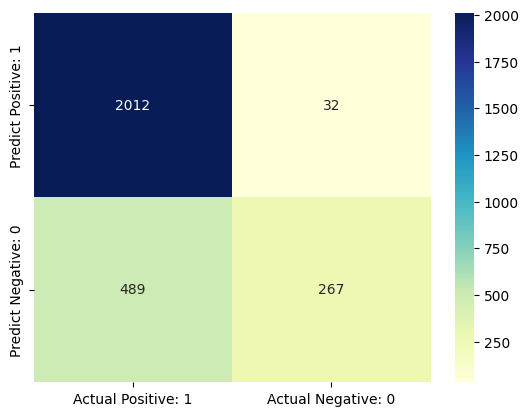

In [48]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive: 1', 'Actual Negative: 0'], 
                                 index=['Predict Positive: 1', 'Predict Negative: 0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [49]:
print(classification_report(yTest, y_predLR))

              precision    recall  f1-score   support

           0       0.80      0.98      0.89      2044
           1       0.89      0.35      0.51       756

    accuracy                           0.81      2800
   macro avg       0.85      0.67      0.70      2800
weighted avg       0.83      0.81      0.78      2800



In [50]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [51]:
# print classification accuracy
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

# print classification error
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Classification error : {0:0.4f}'.format(classification_error))

# print precision score
precision = TP / float(TP + FP)
print('Precision : {0:0.4f}'.format(precision))

# print recall score
recall = TP / float(TP + FN)
print('Recall or Sensitivity : {0:0.4f}'.format(recall))

# print specificity
specificity = TN / (TN + FP)
print('Specificity : {0:0.4f}'.format(specificity))

Classification accuracy : 0.8139
Classification error : 0.1861
Precision : 0.9843
Recall or Sensitivity : 0.8045
Specificity : 0.8930


_[Table of Contents](#toc)_

<a id='multilogreg'></a>
## Multi-Class Logistic Regression

In [52]:
labelRFMTO = logregClassification['labelRFMTO']
labelRFMRC = logregClassification['labelRFMRC']
labelRFMFR = logregClassification['labelRFMFR']
labelRFMMO = logregClassification['labelRFMMO']

In [53]:
mData = [categoriesAnalysed, departmentsAnalysed, activitiesAnalysed, allAnalyzed]
mLabels = [labelRFMRC, labelRFMFR, labelRFMMO, labelRFMTO]
mDataType = ['categoriesAnalysed', 'departmentsAnalysed', 'activitiesAnalysed', 'allAnalyzed']
mLabelType = ['labelRFMRC', 'labelRFMFR', 'labelRFMMO', 'labelRFMTO']

In [54]:
# function for calculating multi-class logistic regression

'''
paramter xTrain, yTrain, xTest, yTest
initiate logistic regression model
fit logistic regression model
predict y, calculate accuracy
return accuracy
'''

def multiLogReg(xTrain, yTrain, xTest, yTest):
    multiLogRegression = LogisticRegression(multi_class="multinomial", random_state = 42) # Hitchhiker's Guide to the Galaxy
    multiLogRegression.fit(xTrain, yTrain)
    y_predLR = multiLogRegression.predict(xTest)
    accMLR = accuracy_score(yTest, y_predLR)
    return accMLR

In [55]:
# calculate logistic regression accuracy for all combinations of co-curricular data and binary labels, appending resuts to list
multiAccLR = []
for indexX, x in enumerate(mData): # iterate through the four columns of co-curricular data (categoriesAnalysed, departmentsAnalysed, activitiesAnalysed, allAnalyzed)
    for indexY, y in enumerate(mLabels): # iterate through the four columns of labels (RFMRC, RFMFR, RFMMO, RFMTO)
        trainLabel = y[ : 14000] # split the training data, to be first 14,000 values
        testLabel = y[14000 : ] # split the test data, to be first 14,000 values
        tfidf = TfidfVectorizer()
        tfidf_matrix = tfidf.fit_transform(x) # vectorize the co-curricular data
        trainData = tfidf_matrix[ : 14000] # split the training data, to be first 14,000 values
        testData = tfidf_matrix[14000 : ] # split the test data, to be first 14,000 values
        xTrain, xTest, yTrain, yTest = train_test_split(trainData, trainLabel, test_size = 0.2, random_state = 42) # split the training data into training and validation
        le = LabelEncoder()
        y_trainLE = le.fit_transform(yTrain)
        accMLR = multiLogReg(xTrain, yTrain, xTest, yTest) # call binary logistic regression function defined above
        print(accMLR)
        multiAccLR.append(accMLR) # append returned accuracy score from eac binary logistic regression model

# multiAccLR

0.8278571428571428
0.7485714285714286
0.9989285714285714
0.7367857142857143
0.8325
0.7853571428571429
0.9989285714285714
0.765
0.8289285714285715
0.7396428571428572
0.9989285714285714
0.7310714285714286
0.8367857142857142
0.7903571428571429
0.9989285714285714
0.7717857142857143


In [56]:
LogRegDF['multiLabels'] = LogRegDF['Labels']
LogRegDF['multiLabels'] = LogRegDF['multiLabels'].str.replace('binary', 'multi')

In [57]:
# add accuracy results to dataframe
LogRegDF['MultiNomialAccuracy'] = multiAccLR
LogRegDF.sort_values('BinaryAccuracy', ascending=False)

,Co-Curricular,Labels,BinaryAccuracy,multiLabels,MultiNomialAccuracy
2,categoriesAnalysed,binaryRFMMO,0.998929,multiRFMMO,0.998929
6,departmentsAnalysed,binaryRFMMO,0.998929,multiRFMMO,0.998929
10,activitiesAnalysed,binaryRFMMO,0.998929,multiRFMMO,0.998929
14,allAnalyzed,binaryRFMMO,0.998929,multiRFMMO,0.998929
12,allAnalyzed,binaryRFMRC,0.866786,multiRFMRC,0.836786
4,departmentsAnalysed,binaryRFMRC,0.856786,multiRFMRC,0.832500
0,categoriesAnalysed,binaryRFMRC,0.850357,multiRFMRC,0.827857
8,activitiesAnalysed,binaryRFMRC,0.850000,multiRFMRC,0.828929
13,allAnalyzed,binaryRFMFR,0.821429,multiRFMFR,0.790357
5,departmentsAnalysed,binaryRFMFR,0.817500,multiRFMFR,0.785357


In [58]:
rowDict = [{'Algorithm':'Univariate LogisticRegression', 'Label':'binaryRFMTO', 'Accuracy':0.813929}, {'Algorithm':'Univariate LogisticRegression', 'Label':'multiRFMTO', 'Accuracy':0.771786}]
logReg = pd.DataFrame.from_dict(rowDict)
logReg

,Algorithm,Label,Accuracy
0,Univariate LogisticRegression,binaryRFMTO,0.813929
1,Univariate LogisticRegression,multiRFMTO,0.771786


### Summary

For a simple start, logistic regression analysed the four sets of co-curricular values (categories, departments, activities and all), for the four sets of labels (Recency, Frequency, Monetary and Total).

As shown in the table above, the results are very high for Monetary scores, which is expected given that these students have made donations. The Recency scores are also high, and not unexpected, given that the data is mostly recent, and students are more likely to give recently.

**The most relevant analysis is therefore 'allAnalyzed' with RFMTO, which achieved a multinomial accuracy score of 0.771.**

But this analysis shows that the focus can be on classification of the 'allAnalyzed' data, with the target labels to be the RFM Total values.

_[Table of Contents](#toc)_

<a id='dtree'></a>
## Decision Tree

In [59]:
dtClassification = pd.DataFrame(columns = ['Algorithm', 'Label', 'Accuracy'])

In [60]:
# create new dataframe for the classification analysis
studentClassification = studentDataset.copy()

In [61]:
studentClassification.drop(['StartYear', 'Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 'Cat7', 'Cat8', 'Cat9', 'Cat10', 'Cat11', 'Cat12', 'Cat13', 'Cat14', 'Cat15', 'Cat16', 'Dept1', 'Dept2', 'Dept3', 'Dept4', 'Dept5', 'Dept6', 'Dept7', 'Dept8', 'Dept9', 'Dept10', 'Dept11', 'Dept12', 'Dept13', 'Dept14', 'Dept15', 'Dept16', 'LifetimeDollars', 'LifetimeGifts', 'FirstAmount', 'LargestAmount', 'Activity1', 'Activity2', 'Activity3', 'Activity4', 'Activity5', 'Activity6', 'Activity7', 'Activity8', 'Activity9', 'Activity10', 'Activity11', 'Activity12', 'AllCategories', 'AllDepartments', 'AllActivities', 'binaryRFMRC', 'binaryRFMFR', 'binaryRFMMO', 'binaryRFMTO', 'labelRFMRC', 'labelRFMFR', 'labelRFMMO', 'labelRFMTO'], axis = 1, inplace = True)

In [62]:
Mbins = 10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
Mlabels = []
for i in range(1, Mbins):
    Mlabels.append(i)
    studentClassification['labelRFMTO'] = pd.cut(studentClassification['RFMTO'], bins = i, labels = Mlabels)

In [63]:
studentClassification

,Sort,RFMRC,RFMFR,RFMMO,RFMTO,Exclusions,Postal,Constituent,Graduation,Faculty,Degree,FirstYear,FirstArea,FirstSolicitation,LargestYear,LargestArea,LargestSolicitation,categoriesAnalysed,departmentsAnalysed,activitiesAnalysed,allAnalyzed,labelRFMTO
0,8g31t83,20,15,6,41,Contact,T2,Alumnus,2017.0,Public Affairs,Bachelor of Arts,2017.0,Athletics,Email,2021.0,Athletics,Email,academic success academic success athletics an...,learning support services university administr...,alumni athletics volunteeralumni association e...,academic success academic success athletics an...,6
1,8gX1t83,0,0,0,0,Contact,K1,Alumnus Employee,2014.0,Public Affairs,Bachelor of Arts,None,None,None,None,None,None,academic success academic success academic suc...,learning support services learning support ser...,alumni association executivealumni association...,academic success academic success academic suc...,1
2,ygz1t8,20,20,2,42,Contact,K1,Alumnus,2017.0,Engineering & Design,Bachelor of Engineering,2013.0,Faculty:Engineering & Design,Levy,2019.0,University Wide,Email,academic success academic success clubs/societ...,faculty of engineering faculty of engineering ...,student volunteeralumni association executive,academic success academic success clubs/societ...,6
3,6gZ1t83,0,0,0,0,Contact,J9,Alumnus,2009.0,School of Business,Bachelor of Commerce,None,None,None,None,None,None,leadership and development,student government,alumni award winneralumni award winner winnera...,leadership and development student government ...,1
4,3g21t87,0,0,0,0,Contact,K2,Alumnus,2011.0,School of Business,Bachelor of Commerce,None,None,None,None,None,None,clubs/societies/associations leadership and de...,school of business school of business,alumni award winner winner,clubs/societies/associations leadership and de...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17709,9g91t88,0,0,0,0,Contact,K1,Alumnus,2019.0,Arts & Social Sciences,Master's,None,None,None,None,None,None,volunteer/ambassadors,school of linguistics,,volunteer/ambassadors school of linguistics,1
17710,jgj1t8Z3f,0,0,0,0,Contact,K1,Alumnus,2020.0,Arts & Social Sciences,Master's,None,None,None,None,None,None,volunteer/ambassadors,school of linguistics,,volunteer/ambassadors school of linguistics,1
17711,jgZ1t8454,0,0,0,0,Contact,S7,Alumnus,2019.0,Public Affairs,Master's,None,None,None,None,None,None,volunteer/ambassadors,school of public policy and administration,,volunteer/ambassadors school of public policy ...,1
17712,jgZ1t8693,0,0,0,0,Contact,N0,Alumnus,2019.0,Public Affairs,Master's,None,None,None,None,None,None,volunteer/ambassadors,school of public policy and administration,,volunteer/ambassadors school of public policy ...,1


In [64]:
# unique_labelRFMTO = studentClassification['labelRFMTO'].unique()
# unique_labelRFMTO
unique = studentClassification['Faculty'].unique()
len(unique)

6

In [65]:
# unique_RFMTO = studentClassification['RFMTO'].unique()
# unique_RFMTO

In [66]:
# len(unique_RFMTO)

In [67]:
# len(unique_labelRFMTO)

In [68]:
allAnalyzed = studentClassification['allAnalyzed'].tolist()
categoriesAnalysed = studentClassification['categoriesAnalysed'].tolist()
departmentsAnalysed = studentClassification['departmentsAnalysed'].tolist()
activitiesAnalysed = studentClassification['activitiesAnalysed'].tolist()
labelRFMTO = studentClassification['labelRFMTO']
data = [categoriesAnalysed, departmentsAnalysed, activitiesAnalysed, allAnalyzed]
dataType = ['categoriesAnalysed', 'departmentsAnalysed', 'activitiesAnalysed', 'allAnalyzed']

In [69]:
# function for calculating Decision Tree

def dTree(xTrain, yTrain, xTest, yTest):
    
    '''
    paramters xTrain, yTrain, xTest, yTest
    initiate Decision Tree model
    fit Decision Tree model
    predict y, calculate accuracy
    return accuracy
    '''

    dtCLF = DecisionTreeClassifier(criterion = 'entropy', random_state = 42) # Hitchhiker's Guide to the Galaxy
    dtCLF.fit(xTrain, yTrain)
    y_predDT = dtCLF.predict(xTest)
    acc = accuracy_score(yTest, y_predDT)
    return acc

In [70]:
# calculate logistic regression accuracy for all combinations of co-curricular data and binary labels, appending resuts to list
DTacc = []
for indexX, x in enumerate(data): # iterate through the four columns of co-curricular data (categoriesAnalysed, departmentsAnalysed, activitiesAnalysed, allAnalyzed)
    trainLabel = labelRFMTO[ : 14000] # split the training data, to be first 14,000 values
    testLabel = labelRFMTO[14000 : ] # split the test data, to be first 14,000 values
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(x) # vectorize the co-curricular data
    trainData = tfidf_matrix[ : 14000] # split the training data, to be first 14,000 values
    testData = tfidf_matrix[14000 : ] # split the test data, to be first 14,000 values
    xTrain, xTest, yTrain, yTest = train_test_split(trainData, trainLabel, test_size = 0.2, random_state = 42) # split the training data into training and validation
    le = LabelEncoder()
    y_trainLE = le.fit_transform(yTrain)
    accDT = dTree(xTrain, yTrain, xTest, yTest) # call binary logistic regression function defined above
    print(accDT)
    rowDict = {'Algorithm':'Univariate DecisionTree', 'Label':dataType[indexX], 'Accuracy':accDT}
    DTacc.append(rowDict) # append returned accuracy score from each binary logistic regression model


0.6989285714285715
0.7260714285714286
0.7242857142857143
0.71


In [71]:
# DTacc

In [72]:
dtClassification = pd.DataFrame.from_dict(DTacc)

In [73]:
dtClassification

,Algorithm,Label,Accuracy
0,Univariate DecisionTree,categoriesAnalysed,0.698929
1,Univariate DecisionTree,departmentsAnalysed,0.726071
2,Univariate DecisionTree,activitiesAnalysed,0.724286
3,Univariate DecisionTree,allAnalyzed,0.710000


In [74]:
cocurricularClassification = pd.concat([logReg, dtClassification], ignore_index=True)
cocurricularClassification

,Algorithm,Label,Accuracy
0,Univariate LogisticRegression,binaryRFMTO,0.813929
1,Univariate LogisticRegression,multiRFMTO,0.771786
2,Univariate DecisionTree,categoriesAnalysed,0.698929
3,Univariate DecisionTree,departmentsAnalysed,0.726071
4,Univariate DecisionTree,activitiesAnalysed,0.724286
5,Univariate DecisionTree,allAnalyzed,0.710000


### Summary

The Decision Tree algorithm did not perform better than the Logistic Regression algoritm, using the same data.

As such, categorical analysis will be applied to the other dependent variables, such as Exclusions, Constituents, etc.

For these analyses, only the 'allAnalyzed' data will be used.

_[Table of Contents](#toc)_

<a id='categorical'></a>
# 5. Categorical Analysis

In [75]:
# create new dataframe for the categorical analysis
studentCategorical = studentClassification.copy()

In [76]:
studentCategorical.drop(['categoriesAnalysed', 'departmentsAnalysed', 'activitiesAnalysed'], axis = 1, inplace = True)

In [77]:
studentCategorical

,Sort,RFMRC,RFMFR,RFMMO,RFMTO,Exclusions,Postal,Constituent,Graduation,Faculty,Degree,FirstYear,FirstArea,FirstSolicitation,LargestYear,LargestArea,LargestSolicitation,allAnalyzed,labelRFMTO
0,8g31t83,20,15,6,41,Contact,T2,Alumnus,2017.0,Public Affairs,Bachelor of Arts,2017.0,Athletics,Email,2021.0,Athletics,Email,academic success academic success athletics an...,6
1,8gX1t83,0,0,0,0,Contact,K1,Alumnus Employee,2014.0,Public Affairs,Bachelor of Arts,None,None,None,None,None,None,academic success academic success academic suc...,1
2,ygz1t8,20,20,2,42,Contact,K1,Alumnus,2017.0,Engineering & Design,Bachelor of Engineering,2013.0,Faculty:Engineering & Design,Levy,2019.0,University Wide,Email,academic success academic success clubs/societ...,6
3,6gZ1t83,0,0,0,0,Contact,J9,Alumnus,2009.0,School of Business,Bachelor of Commerce,None,None,None,None,None,None,leadership and development student government ...,1
4,3g21t87,0,0,0,0,Contact,K2,Alumnus,2011.0,School of Business,Bachelor of Commerce,None,None,None,None,None,None,clubs/societies/associations leadership and de...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17709,9g91t88,0,0,0,0,Contact,K1,Alumnus,2019.0,Arts & Social Sciences,Master's,None,None,None,None,None,None,volunteer/ambassadors school of linguistics,1
17710,jgj1t8Z3f,0,0,0,0,Contact,K1,Alumnus,2020.0,Arts & Social Sciences,Master's,None,None,None,None,None,None,volunteer/ambassadors school of linguistics,1
17711,jgZ1t8454,0,0,0,0,Contact,S7,Alumnus,2019.0,Public Affairs,Master's,None,None,None,None,None,None,volunteer/ambassadors school of public policy ...,1
17712,jgZ1t8693,0,0,0,0,Contact,N0,Alumnus,2019.0,Public Affairs,Master's,None,None,None,None,None,None,volunteer/ambassadors school of public policy ...,1


In [78]:
studentTFIDF = studentCategorical.copy()

In [79]:
studentTFIDF.columns

Index(['Sort', 'RFMRC', 'RFMFR', 'RFMMO', 'RFMTO', 'Exclusions', 'Postal',
       'Constituent', 'Graduation', 'Faculty', 'Degree', 'FirstYear',
       'FirstArea', 'FirstSolicitation', 'LargestYear', 'LargestArea',
       'LargestSolicitation', 'allAnalyzed', 'labelRFMTO'],
      dtype='object')

In [80]:
studentTFIDF.drop(['Sort', 'RFMRC', 'RFMFR', 'RFMMO', 'RFMTO', 'Graduation', 'FirstYear', 'LargestYear', 'labelRFMTO'], axis = 1, inplace = True)

In [81]:
studentTFIDF

,Exclusions,Postal,Constituent,Faculty,Degree,FirstArea,FirstSolicitation,LargestArea,LargestSolicitation,allAnalyzed
0,Contact,T2,Alumnus,Public Affairs,Bachelor of Arts,Athletics,Email,Athletics,Email,academic success academic success athletics an...
1,Contact,K1,Alumnus Employee,Public Affairs,Bachelor of Arts,None,None,None,None,academic success academic success academic suc...
2,Contact,K1,Alumnus,Engineering & Design,Bachelor of Engineering,Faculty:Engineering & Design,Levy,University Wide,Email,academic success academic success clubs/societ...
3,Contact,J9,Alumnus,School of Business,Bachelor of Commerce,None,None,None,None,leadership and development student government ...
4,Contact,K2,Alumnus,School of Business,Bachelor of Commerce,None,None,None,None,clubs/societies/associations leadership and de...
...,...,...,...,...,...,...,...,...,...,...
17709,Contact,K1,Alumnus,Arts & Social Sciences,Master's,None,None,None,None,volunteer/ambassadors school of linguistics
17710,Contact,K1,Alumnus,Arts & Social Sciences,Master's,None,None,None,None,volunteer/ambassadors school of linguistics
17711,Contact,S7,Alumnus,Public Affairs,Master's,None,None,None,None,volunteer/ambassadors school of public policy ...
17712,Contact,N0,Alumnus,Public Affairs,Master's,None,None,None,None,volunteer/ambassadors school of public policy ...


In [82]:
studentTFIDF.columns

Index(['Exclusions', 'Postal', 'Constituent', 'Faculty', 'Degree', 'FirstArea',
       'FirstSolicitation', 'LargestArea', 'LargestSolicitation',
       'allAnalyzed'],
      dtype='object')

In [84]:
cols = ['Exclusions', 'Postal', 'Constituent', 'Faculty', 'Degree', 'FirstArea', 'FirstSolicitation', 'LargestArea', 'LargestSolicitation', 'allAnalyzed']
studentTFIDF["allCategorical"] = studentTFIDF[cols].apply(lambda x: ' '.join(x.dropna()), axis=1)

In [86]:
studentTFIDF

,Exclusions,Postal,Constituent,Faculty,Degree,FirstArea,FirstSolicitation,LargestArea,LargestSolicitation,allAnalyzed,allCategorical
0,Contact,T2,Alumnus,Public Affairs,Bachelor of Arts,Athletics,Email,Athletics,Email,academic success academic success athletics an...,Contact T2 Alumnus Public Affairs Bachelor of ...
1,Contact,K1,Alumnus Employee,Public Affairs,Bachelor of Arts,None,None,None,None,academic success academic success academic suc...,Contact K1 Alumnus Employee Public Affairs Bac...
2,Contact,K1,Alumnus,Engineering & Design,Bachelor of Engineering,Faculty:Engineering & Design,Levy,University Wide,Email,academic success academic success clubs/societ...,Contact K1 Alumnus Engineering & Design Bachel...
3,Contact,J9,Alumnus,School of Business,Bachelor of Commerce,None,None,None,None,leadership and development student government ...,Contact J9 Alumnus School of Business Bachelor...
4,Contact,K2,Alumnus,School of Business,Bachelor of Commerce,None,None,None,None,clubs/societies/associations leadership and de...,Contact K2 Alumnus School of Business Bachelor...
...,...,...,...,...,...,...,...,...,...,...,...
17709,Contact,K1,Alumnus,Arts & Social Sciences,Master's,None,None,None,None,volunteer/ambassadors school of linguistics,Contact K1 Alumnus Arts & Social Sciences Mast...
17710,Contact,K1,Alumnus,Arts & Social Sciences,Master's,None,None,None,None,volunteer/ambassadors school of linguistics,Contact K1 Alumnus Arts & Social Sciences Mast...
17711,Contact,S7,Alumnus,Public Affairs,Master's,None,None,None,None,volunteer/ambassadors school of public policy ...,Contact S7 Alumnus Public Affairs Master's Non...
17712,Contact,N0,Alumnus,Public Affairs,Master's,None,None,None,None,volunteer/ambassadors school of public policy ...,Contact N0 Alumnus Public Affairs Master's Non...


_[Table of Contents](#toc)_

<a id='catDT'></a>
## Decision Tree

In [87]:
# define categorical values for Decision Tree algoritm

X = studentTFIDF['allCategorical']
y = studentCategorical['labelRFMTO']

In [88]:
trainLabel = y[ : 14000] # split the training data, to be first 14,000 values
testLabel = y[14000 : ] # split the test data, to be first 14,000 values
trainData = X[ : 14000] # split the training data, to be first 14,000 values
testData = X[14000 : ] # split the test data, to be first 14,000 values

In [89]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(trainData) # vectorize the co-curricular data

In [90]:
X_train ,X_test, y_train, y_test = train_test_split(tfidf_matrix, trainLabel, test_size= 0.2, random_state= 1)
print('X_train dimension= ', X_train.shape)
print('X_test dimension= ', X_test.shape)
print('y_train dimension= ', y_train.shape)
print('y_train dimension= ', y_test.shape)

X_train dimension=  (11200, 410)
X_test dimension=  (2800, 410)
y_train dimension=  (11200,)
y_train dimension=  (2800,)


In [91]:
dtCatCLF = DecisionTreeClassifier(criterion = 'entropy', random_state = 42) # Hitchhiker's Guide to the Galaxy

In [92]:
dtCatCLF.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [102]:
y_predCatDT = dtCatCLF.predict(X_test)
accDT = accuracy_score(y_test, y_predCatDT)
accDT

0.8467857142857143

In [98]:
cocurricularClassification.loc[len(cocurricularClassification.index)] = ['TFIDF DecisionTree', 'allAnalyzed', accDT]
cocurricularClassification

,Algorithm,Label,Accuracy
0,Univariate LogisticRegression,binaryRFMTO,0.813929
1,Univariate LogisticRegression,multiRFMTO,0.771786
2,Univariate DecisionTree,categoriesAnalysed,0.698929
3,Univariate DecisionTree,departmentsAnalysed,0.726071
4,Univariate DecisionTree,activitiesAnalysed,0.724286
5,Univariate DecisionTree,allAnalyzed,0.710000
6,TFIDF DecisionTree,allAnalyzed,0.846786


<a id='catNB'></a>
## Naive Bayes

In [103]:
mnbCLF = MultinomialNB()
mnbCLF.fit(X_train, y_train)

MultinomialNB()

In [105]:
y_predNMB = mnbCLF.predict(X_test)
accMNB = accuracy_score(y_test, y_predNMB)
accMNB

0.8521428571428571

In [106]:
cocurricularClassification.loc[len(cocurricularClassification.index)] = ['TFIDF Multinomial Naive Bayes', 'allAnalyzed', accMNB]
cocurricularClassification

,Algorithm,Label,Accuracy
0,Univariate LogisticRegression,binaryRFMTO,0.813929
1,Univariate LogisticRegression,multiRFMTO,0.771786
2,Univariate DecisionTree,categoriesAnalysed,0.698929
3,Univariate DecisionTree,departmentsAnalysed,0.726071
4,Univariate DecisionTree,activitiesAnalysed,0.724286
5,Univariate DecisionTree,allAnalyzed,0.710000
6,TFIDF DecisionTree,allAnalyzed,0.846786
7,TFIDF Multinomial Naive Bayes,allAnalyzed,0.852143


<a id='catXGB'></a>
## XGBoost